In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import ltcl
import numpy as np
from ltcl.datasets.sim_dataset import SimulationDataset
from ltcl.modules.lvae import AfflineVAESynthetic
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = True
device = torch.device("cuda:0" if use_cuda else "cpu")

In [4]:
data = SimulationDataset()
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=1280, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [5]:
for batch in train_loader:
    break

In [6]:
for key in batch:
    batch[key] = batch[key].to(device)

In [7]:
batch['xt_'].min()

tensor(0.0301, device='cuda:0')

(array([1.000e+00, 1.000e+00, 3.000e+00, 2.600e+01, 1.730e+02, 1.101e+03,
        1.060e+03, 1.620e+02, 2.700e+01, 6.000e+00]),
 array([-11.689354  ,  -9.746808  ,  -7.8042626 ,  -5.861717  ,
         -3.9191716 ,  -1.9766259 ,  -0.03408032,   1.9084653 ,
          3.8510108 ,   5.7935567 ,   7.736102  ], dtype=float32),
 <BarContainer object of 10 artists>)

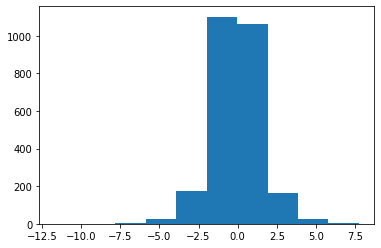

In [8]:
plt.hist(batch['yt'].cpu().numpy().reshape(-1,4)[:,3])

In [11]:
model = AfflineVAESynthetic(4,4,2).to(device)

In [12]:
model

AfflineVAESynthetic(
  (net): BetaVAE_MLP(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Linear(in_features=128, out_features=8, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)

In [433]:
model = model.load_from_checkpoint("/home/cmu_wyao/checkpoints/linear_vae/lightning_logs/version_24/checkpoints/epoch=9-step=78089.ckpt",
                                   input_dim = 4, z_dim=4, lag=2)

/home/cmu_wyao/projects/ltcl/ltcl/modules/components/beta.py:166: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [420]:
model.to('cpu')

AfflineVAESynthetic(
  (net): BetaVAE_MLP(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Linear(in_features=128, out_features=8, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)

In [421]:
batch_size = 64
spline_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.spline.parameters()), 
                                    lr=1e-3,
                                    weight_decay=0.0)
# Warm-start the prior to standard normal dist
for step in range(5000):
    latent_size = 4
#     y_1 = torch.exp(torch.normal(0, 1, size=(batch_size, latent_size//2)))
# #     y_1 = torch.normal(0, 1, size=(batch_size, latent_size//2))
#                 # y_2 = torch.rand(batch_size, latent_size//2) - 0.5
#     y_2 = torch.distributions.laplace.Laplace(0,1).rsample((batch_size, latent_size//2))
# #     y_2 = torch.normal(0, 1, size=(batch_size, latent_size//2))
    y_t = torch.distributions.laplace.Laplace(0,1).rsample((batch_size, latent_size))
    dataset = y_t.to(device)
    spline_optimizer.zero_grad()
    z, logabsdet = model.spline(dataset)
    logp = model.spline.base_dist.log_prob(z) + logabsdet
    loss = -torch.mean(logp)
    loss.backward(retain_graph=True)
    spline_optimizer.step()
torch.save(model.spline.state_dict(), "/home/cmu_wyao/spline.pth")

ValueError: optimizer got an empty parameter list

In [160]:
eps = model.sample(batch["xt"].cpu())
eps = eps.detach().cpu().numpy()

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


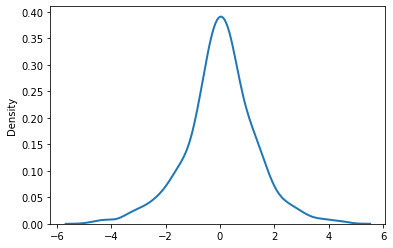

In [161]:
sns.distplot(eps[:,3], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, label="prior");

In [106]:
sns.distplot(eps_res[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, label="posterior

SyntaxError: EOL while scanning string literal (<ipython-input-106-b8e943d6a0d4>, line 4)

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


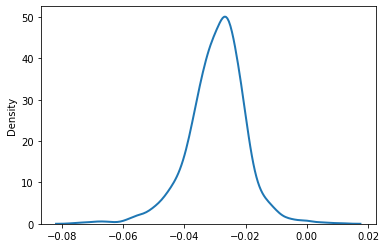

In [192]:
sns.distplot(eps_res[:,3], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, label="posterior");

In [434]:
W2 = model.trans_func.w[0].detach().cpu().numpy()
W1 = model.trans_func.w[1].detach().cpu().numpy()
B2 = -W2
B1 = -W1

In [435]:
BB2 = np.load("/home/cmu_wyao/projects/data/linear_nongaussian/W2.npy")
BB1 = np.load("/home/cmu_wyao/projects/data/linear_nongaussian/W1.npy")

In [436]:
b = np.concatenate((B1,B2), axis=0)
bb = np.concatenate((BB1,BB2), axis=0)
# b = B2
# bb = BB2
C = np.zeros((4,4))
for i in range(4):
    C[i] = -np.abs(np.corrcoef(np.concatenate((b[:,i:i+1], bb),axis=1), rowvar=False)[0,1:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
bb = bb[:, col_ind]
for col in range(4):
    if np.corrcoef(np.concatenate((b[:,col:col+1], bb),axis=1), rowvar=False)[0,1:][col] < 0:
        bb[:, col] = -bb[:, col]
b = b / np.linalg.norm(b, axis=0).reshape(1, -1)
bb = bb / np.linalg.norm(bb, axis=0).reshape(1, -1)
pred = (b / np.linalg.norm(b, axis=0).reshape(1, -1)).reshape(-1)
true = (bb / np.linalg.norm(bb, axis=0).reshape(1, -1)).reshape(-1)

In [437]:
C[row_ind, col_ind]

array([-0.22177556, -0.09218327, -0.22692744, -0.88170456])

In [401]:
C[row_ind, col_ind]

array([-0.39813407, -0.92957814, -0.24436747, -0.03064014])

In [438]:
b

array([[-0.54263914,  0.42458233,  0.03306229, -0.43974927],
       [ 0.02495718, -0.2185202 ,  0.02526775, -0.14324664],
       [ 0.25488845,  0.45940793, -0.54192406,  0.522279  ],
       [-0.11941154,  0.19643417,  0.09615511, -0.18473135],
       [-0.68516964, -0.4855517 ,  0.3690104 , -0.4695175 ],
       [ 0.05124643,  0.41261044, -0.02932839,  0.01010843],
       [ 0.35874793, -0.2554461 , -0.7312091 ,  0.48239398],
       [-0.15782566, -0.22600074,  0.15377052, -0.16108064]],
      dtype=float32)

In [439]:
bb

array([[-0.5980089 ,  0.21683341, -0.39182225, -0.44806504],
       [-0.12079846,  0.545546  , -0.6663635 , -0.07386426],
       [-0.1893496 ,  0.25210577, -0.11058507,  0.3984242 ],
       [ 0.61947435,  0.6778025 ,  0.14027089, -0.03291513],
       [-0.26748887,  0.14655821, -0.13618793, -0.50111276],
       [ 0.18450661, -0.09920824, -0.42694244,  0.24429446],
       [-0.30625188,  0.14378825, -0.39227146,  0.3013707 ],
       [ 0.09385146, -0.28353617,  0.12580204, -0.48201498]],
      dtype=float32)

In [440]:
C

array([[-0.0419628 , -0.22177556, -0.88261251, -0.17652143],
       [-0.09218327, -0.09527681, -0.41296819, -0.0144553 ],
       [-0.02140064, -0.23888922, -0.80620712, -0.22692744],
       [-0.05522188, -0.00366254, -0.88170456, -0.07344289]])

Text(0, 0.5, 'Ground truth weight')

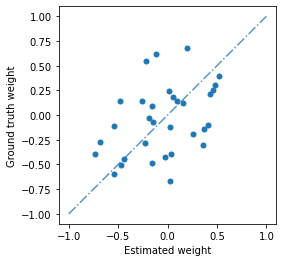

In [441]:
fig, ax = plt.subplots()
ax.scatter(pred, true, s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [-1,1
]

# now plot both limits against eachother
ax.plot(lims, lims, '-.', alpha=0.75, zorder=0)
ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.set_xlabel("Estimated weight")
ax.set_ylabel("Ground truth weight")

In [430]:
def amari_distance(r):
    p = r.shape[0]
    abs_r = np.abs(r)
    l = np.sum(np.sum(abs_r, axis=1, keepdims=True) / np.max(abs_r, axis=1, keepdims=True) - 1, axis=0)
    r = np.sum(np.sum(abs_r, axis=0, keepdims=True) / np.max(abs_r, axis=0, keepdims=True) - 1, axis=1)
    return 1/(2*p*(p-1)) * (l+r)

In [431]:
am2 = amari_distance(np.linalg.inv(B2) @ BB2)
am1 = amari_distance(np.linalg.inv(B1) @ BB1)
print(f"Amari index: {am2[0], am1[0]}")

Amari index: (0.35062075, 0.22854581)


In [432]:
from sklearn.metrics import r2_score
r2_score(pred,true)

-0.14168433878591458

(array([ 91., 626., 161.,  96.,  66.,  59.,  75.,  51.,  35.,  20.]),
 array([-0.16992928,  0.34165633,  0.8532419 ,  1.3648275 ,  1.8764131 ,
         2.3879986 ,  2.8995843 ,  3.4111698 ,  3.9227555 ,  4.434341  ,
         4.9459267 ], dtype=float32),
 <BarContainer object of 10 artists>)

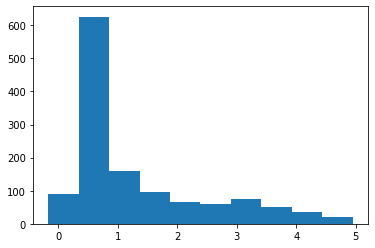

In [61]:
plt.hist(eps[:,1])